## Install and Import

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install pytorch-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 42.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.8 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=a914afb003f0bce5028c60863a401cc6d8e2da7fd5e8e8d67bad9fd308b44dfc
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load Dataset


In [5]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving sample30.csv to sample30.csv


In [6]:
df = pd.read_csv("sample30.csv")

In [7]:
df.shape

(30000, 15)

In [8]:
df.sample(10)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
29229,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-31T00:00:00.000Z,False,True,4,Goes really well when paired with the shampoo ...,Love it!,NaN,NaN,milka,Positive
1483,AVpe_y-I1cnluZ0-bmvh,Yes to Carrots,"Personal Care,Bath, Shower & Soap,Body Wash & ...",Yes To Inc.,Yes To Carrots Nourishing Body Wash,2012-08-03T00:00:00.000Z,False,True,5,I am an avid shower gel person and have shoppe...,"Amazing, clean and fresh!",NaN,NaN,trix,Positive
3434,AVpe5s3RLJeJML43x4eA,Pantene,"Personal Care,Hair Care,Conditioner,Beauty,Sha...",Pantene Pro-V Hair Care,Pantene Pro-V Expert Collection Age Defy Condi...,2016-04-08T00:00:00.000Z,False,NaN,5,This is thick stuff! I was surprised by the co...,Serious conditioning!,NaN,NaN,jennypstrong,Positive
3295,AVpe5JOgilAPnD_xQPfE,Sony Music,"Movies, Music & Books,Music,Rock,Music on CD o...",Columbia,The Script - No Sound Without Silence (cd),2015-01-17T00:00:00Z,NaN,NaN,4,Saw The Script over the summer with One Republ...,Love this band,NaN,NaN,cfrank,Positive
9138,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-03T12:28:02.000Z,NaN,True,5,I really like Clorox products. I have been usi...,Clorox,Kings Mountain,NaN,ppark,Positive
7969,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-01-26T16:53:41.000Z,NaN,True,5,"With kids, Clorox makes my life so much easier...",Great Product,NaN,NaN,letty1,Positive
13360,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-05T00:00:00.000Z,False,True,5,I simply love Clorox. I know when I use the pr...,Why I love Clorox,NaN,NaN,shell622,Positive
5861,AVpf2tw1ilAPnD_xjflC,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),2014-01-04T00:00:00.000Z,NaN,True,5,Good cast and very funny action film.Worth wat...,Very funny action film,NaN,NaN,renegade22,Positive
9034,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-01-26T13:46:37.000Z,NaN,True,5,I have never used another product that works a...,This Product Screams Clean!,Kingstree,NaN,susie72,Positive
207,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-05-27T00:00:00.000Z,False,True,5,"Light weight, yet effective. I don't feel like...",wonderful cream,NaN,NaN,mars305,Positive


In [9]:
import numpy as np

# Assuming you have the initial array
initial_labels = df.user_sentiment.values

result_array = np.empty_like(initial_labels)

# Loop through the original array and map the values
for i in range(len(initial_labels)):
  if initial_labels[i] == "Positive":
    result_array[i] = 1
  else:
    result_array[i] = 0

# Display the result
print(result_array)

# Use np.vectorize to apply the mapping to each element in the initial array
df['trans_labels'] = result_array

df.sample(10)

[1 1 1 ... 1 1 1]


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,trans_labels
29558,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-28T01:36:59.000Z,NaN,True,4,I received this free for testing purposes and ...,Works Good With The Clay System,Buffalo,NaN,laurao,Positive,1
29055,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-06T00:00:00.000Z,False,False,3,This conditioner didn't wow me as much as the ...,Just Okay,NaN,NaN,burntkneechin,Positive,1
26724,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2015-06-12T00:00:00.000Z,NaN,NaN,5,Very cost-effective! I use with my baby..,Five Stars,NaN,NaN,byae57,Positive,1
2697,AVpe59io1cnluZ0-ZgDU,Universal Home Video,"Movies, Music & Books,Movies,Comedy,Movies & T...",Universal,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,2016-08-05T00:00:00.000Z,NaN,True,4,A good comedy movie.it comes with digital hd a...,A good comedy movie,NaN,NaN,raybo,Positive,1
2528,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Twentieth Century Fox,Mike Dave Need Wedding Dates (dvd + Digital),2017-07-14T00:00:00.000Z,NaN,True,5,Hilarious from start to finish. Highly recomme...,Hilarious,NaN,NaN,wormgang,Positive,1
20057,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,I love love love this product! I know that whe...,These are the best!,NaN,NaN,debbie2012,Positive,1
17774,AVpfBSJgilAPnD_xTLf3,Axe,"Personal Care,Deodorants & Antiperspirants,Deo...",Axe,Axe Dry Anti-Perspirant Deodorant Invisible So...,2017-01-18T09:16:39.000Z,NaN,NaN,4,The smell is very clean very nice and simple h...,Great But Not Perfect,San Diego,NaN,mikumiku,Positive,1
22070,AVpfNVsj1cnluZ0-gNQN,Physician's Formula,"Personal Care,Makeup,Concealer & Foundation,Fo...",Physicians Formula,Physicians Formula Powder Palette Mineral Glow...,2016-02-24T00:00:00.000Z,False,True,5,I had a friend tell me to try this out. I'm so...,Beautiful highlighter,NaN,NaN,katiekates2,Positive,1
2449,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Twentieth Century Fox,Mike Dave Need Wedding Dates (dvd + Digital),2017-02-01T00:00:00.000Z,NaN,True,5,entertaining and a fun addition for our movie ...,great comedy for the movie collection,NaN,NaN,gage,Positive,1
24798,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2017-01-15T00:00:00.000Z,NaN,True,5,Had to get it. It's definitely a classic. Espe...,Dope,NaN,NaN,hrdyboy,Positive,1


In [10]:
# Split the dataset into trainset and testset
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(df, test_size=0.1, random_state=42)
trainset.shape

(27000, 16)

In [11]:
# Create sentence and label lists
sentences = trainset.reviews_text.values
# sentences = str(trainset.reviews_title.values) + trainset.reviews_text.values

We need to add special tokens ("[SEP]" and "[CLS]") at the beginning and end of each sentence for XLNet to work properly.

For BERT, the special token pattern looks like this:

    [CLS] + Sentence_A + [SEP] + Sentence_B + [SEP]

Whereas with XLNet the token pattern looks like this:

    Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]
    
For single sentence inputs here, we just need to add [SEP] and [CLS] to the end:

In [12]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = trainset.trans_labels.values
#labels = trainset.reviews_rating.values

## Inputs

Next, import the XLNet tokenizer, used to convert our text into tokens that correspond to XLNet's vocabulary.

In [13]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 798011/798011 [00:01<00:00, 736480.85B/s]


Tokenize the first sentence:
['▁', 'i', '▁am', '▁a', '▁huge', '▁fan', '▁of', '▁the', '▁', 're', 'gene', 'rist', '▁moist', 'ur', 'izer', '.', '▁', 'i', '▁don', "'", 't', '▁leave', '▁my', '▁house', '▁without', '▁it', '.', '▁', 'i', '▁have', '▁used', '▁', 'ola', 'y', '▁products', '▁since', '▁', 'i', '▁have', '▁been', '▁18', '▁years', '▁old', '.', '▁', 'i', '▁am', '▁a', '▁loyal', '▁and', '▁faithful', '▁fan', '▁of', '▁', 'ola', 'y', '▁and', '▁my', '▁skin', '▁proves', '▁it', '.', '▁this', '▁review', '▁was', '▁collected', '▁as', '▁part', '▁of', '▁a', '▁promotion', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [14]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
MAX_LEN = 128

In [15]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [16]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks

In [17]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [18]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)

In [19]:
train_labels

array([1, 1, 1, ..., 1, 0, 1], dtype=object)

In [20]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels.tolist())
validation_labels = torch.tensor(validation_labels.tolist())
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [21]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

In [22]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.5 MB/s eta 0:00:00


In [23]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top.
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [24]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [25]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

In [26]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [27]:


# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 0.2108722795462726


Epoch:  25%|██▌       | 1/4 [11:05<33:15, 665.27s/it]

Validation Accuracy: 0.9551470588235295
Train loss: 0.10724820598253772


Epoch:  50%|█████     | 2/4 [22:06<22:06, 663.18s/it]

Validation Accuracy: 0.9625
Train loss: 0.06859301924341707


Epoch:  75%|███████▌  | 3/4 [33:08<11:02, 662.25s/it]

Validation Accuracy: 0.9633578431372549
Train loss: 0.04173042197462085


Epoch: 100%|██████████| 4/4 [44:08<00:00, 662.12s/it]

Validation Accuracy: 0.9672794117647059


## Training Evaluation

Let's take a look at our training loss over all batches:

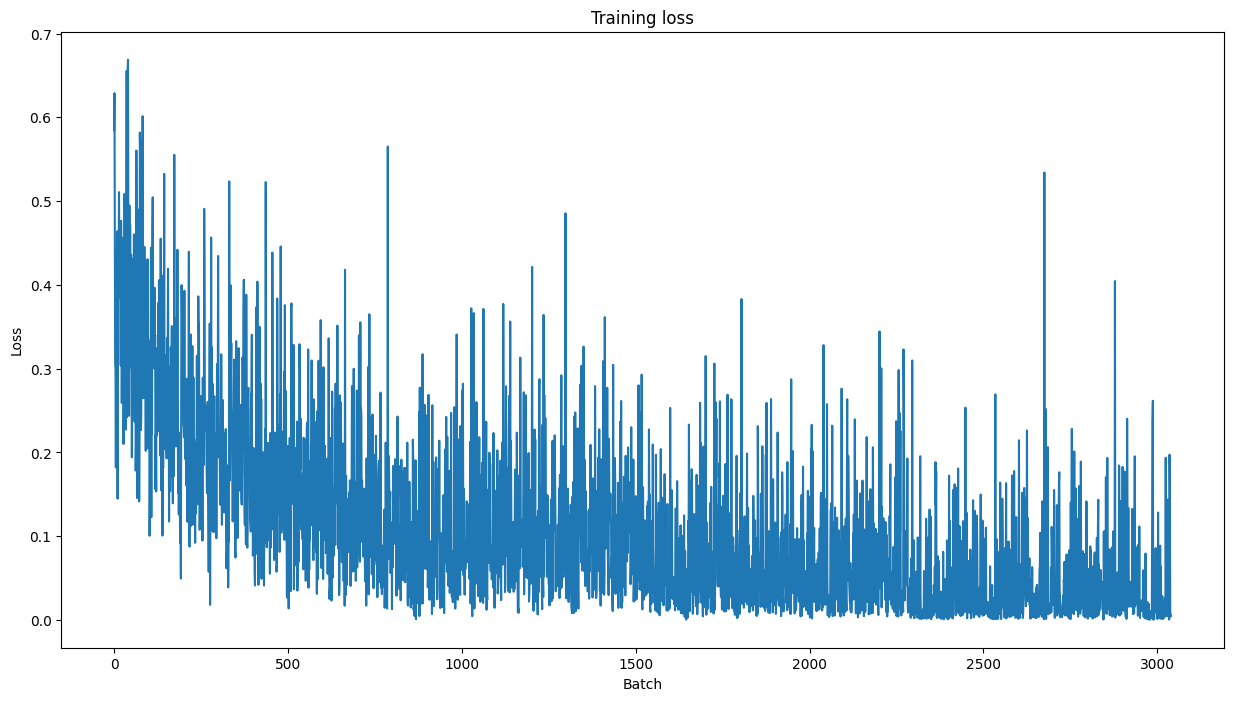

In [29]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [30]:
# Create sentence and label lists
sentences = testset.reviews_text.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = testset.trans_labels.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels.tolist())

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [31]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [32]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [33]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [34]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.8166077583860566

In [41]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
accuracy_score(flat_true_labels, flat_predictions)

0.964

In [36]:
f1_score(flat_true_labels, flat_predictions)

0.9798432250839866

In [37]:
precision_score(flat_true_labels, flat_predictions)

0.9686346863468634

In [43]:
recall_score(flat_true_labels, flat_predictions)

0.9913141993957704

In [38]:
testset['pred_val'] = [-1 if i==0 else 1 for i in flat_predictions.tolist()]
testset

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,trans_labels,pred_val
2308,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Twentieth Century Fox,Mike Dave Need Wedding Dates (dvd + Digital),2016-12-14T00:00:00.000Z,NaN,True,5,I have to admit that I was skeptical about see...,Awesome movie!,NaN,NaN,iplsports,Positive,1,1
22404,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy,"Personal Care,Hair Care,Shampoo,Featured Brand...",Clear,Clear Scalp & Hair Therapy Total Care Nourishi...,2016-08-30T00:00:00.000Z,False,False,1,I use to LOVE Clear... until it changed it's f...,Such a waste....!,NaN,NaN,crysv,Negative,0,1
23397,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2015-06-24T00:00:00.000Z,NaN,True,4,I enjoyed this film because just like the old ...,A page from the old school Godzilla,NaN,NaN,sammhc12,Positive,1,1
25058,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-09-20T00:00:00.000Z,NaN,True,5,SPECIAL FX ARE JUST WAY OVER THE TOP HAVE ALWA...,awesome fx,NaN,NaN,spyder,Positive,1,1
2664,AVpe59io1cnluZ0-ZgDU,Universal Home Video,"Movies, Music & Books,Movies,Comedy,Movies & T...",Universal,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,2016-07-22T00:00:00.000Z,NaN,True,4,If you liked the first movie you will love the...,Greeking it up funny,NaN,NaN,melbellz,Positive,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21481,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2017-03-05T00:00:00.000Z,False,False,1,I have used Exxtra Gel for years. This New for...,New gel AWFUL for curls!!,NaN,NaN,laneyjo,Negative,0,2
26178,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-09-19T00:00:00.000Z,NaN,True,5,Loved the option of having the 3d and the regu...,Great picture quality,NaN,NaN,berglynn06,Positive,1,1
27445,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2016-01-04T00:00:00.000Z,NaN,True,4,This is a great video for little kids! Our fam...,fun video for the kids,NaN,NaN,marykaycruz,Positive,1,1
1723,AVpe31o71cnluZ0-YrSD,Warner Bros.,"Movies, Music & Books,Movies,Comedy,Movies & T...",TIME WARNER,Dark Shadows (includes Digital Copy) (ultravio...,2013-12-27T00:00:00.000Z,NaN,True,5,I was not sure I would like this movie because...,Just a fun movie.,NaN,NaN,granpadan,Positive,1,1


# Similarity Matrix

recommend based on predictions

In [79]:
# Construct index: users, columns: preoduct_id, values: sentiment_prediction
df_reco = testset[["name", "pred_val", "reviews_username"]]
# train, test = train_test_split(df_reco, test_size=0.30, random_state=42)

df_pivot = pd.pivot_table(
    testset,
    index='reviews_username',
    columns='name',
    values="pred_val",
).fillna(0)

df_pivot[df_pivot.iloc[:,1]!=0]
df_pivot.to_csv("pivot1.csv")

In [77]:
from sklearn.metrics.pairwise import cosine_similarity
m1_similarity = cosine_similarity(df_pivot)
#for elem in m1_similarity[0]:
#  print(elem)
m1_similarity.shape
df = pd.DataFrame(m1_similarity)
df.to_csv("m1.csv", index=False)

recommend based on original data

In [75]:
# Construct index: users, columns: product_id, values: sentiment_users
# trans_label: transform sentiment into 1/0
df_reco = testset[["name", "pred_val","trans_labels","reviews_rating", "reviews_username"]]
# train, test = train_test_split(df_reco, test_size=0.30, random_state=42)

df_pivot2 = pd.pivot_table(
    testset,
    index='reviews_username',
    columns='name',
    values="trans_labels",
).fillna(0)


df_pivot2.to_csv("pivot2.csv")

In [78]:
from sklearn.metrics.pairwise import cosine_similarity
m2_similarity = cosine_similarity(df_pivot2)
#for elem in m1_similarity[0]:
#  print(elem)
df = pd.DataFrame(m2_similarity)
df.to_csv("m2.csv", index=False)